In [ ]:
!pip install dpkt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 kB 7.8 MB/s eta 0:00:00


In [ ]:
!pip install scapy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scapy: filename=scapy-2.5.0-py2.py3-none-any.whl size=1444325 sha256=fe19dda85b931ce2376d80039bff9d0ad219568220ac0e1d7f956a546d686950
  Stored in directory: /root/.cache/pip/wheels/82/b7/03/8344d8cf6695624746311bc0d389e9d05535ca83c35f90241d
Successfully built scapy


In [ ]:
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive

drive.mount(ROOT)           # we mount the google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/23Project

/content/drive/MyDrive/23Project


In [ ]:
from sklearn.model_selection import train_test_split # To seperate train set and test set
from sklearn.linear_model import LinearRegression # To use linear regression
from sklearn.metrics import classification_report

# For polynomial regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

# For LSTM model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import dpkt # for parsing .pcap file
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # to show data scatter, pgraph
import seaborn as sns
from scapy.all import *
%matplotlib inline

# Traffic Prediction & Model Estimation

In [ ]:
# pcap에서 data 끌어오기
packetsFrom03 = rdpcap("packetcapture_pi03.pcap")
packetsFrom04 = rdpcap("packetcapture_pi04.pcap")
packetsFrom05 = rdpcap("packetcapture_pi05.pcap")

In [ ]:
# LSTM 입력 데이터 생성
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)



---



---



# LSTM Model

# Raspberry Pi 3

IP address = 192.168.0.3

Mac address = e4:5f:01:71:07:ca

1. Visualize RPi3 captured data

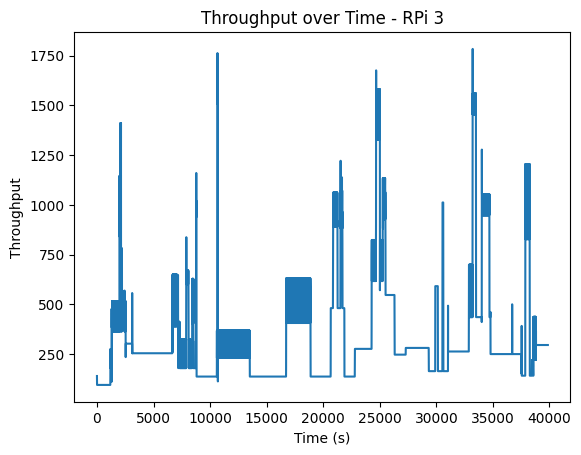

In [ ]:
# 간격과 throughput을 저장할 배열 초기화
interval = 5  # 5초 간격
throughputs = []

# 시작 시간 설정
start_time = packetsFrom03[0].time

# 패킷을 5초 간격으로 그룹화하여 throughput 계산
current_group = []
for packet in packetsFrom03:
    current_group.append(packet)
    if packet.time - start_time >= interval:
        # 패킷 크기를 고려한 throughput 계산 (총 데이터양 / 간격)
        total_bytes = sum(len(pkt) for pkt in current_group)
        throughput = total_bytes / interval
        throughputs.append(throughput)
        # 새로운 그룹 시작
        current_group = []
        start_time = packet.time

# x, y 값 배열 생성
time_axis = np.arange(0, len(throughputs) * interval, interval)
throughput_valuesPi3 = np.array(throughputs)

# 그래프 생성
plt.plot(time_axis, throughput_valuesPi3)
plt.xlabel('Time (s)')
plt.ylabel('Throughput')
plt.title('Throughput over Time - RPi 3')
plt.show()

2. Prediction



In [ ]:
# 데이터 전처리
data = np.array(throughput_valuesPi3)
time_axis = np.array(time_axis)
data = data.reshape(-1, 1)  # LSTM 모델 입력 형태에 맞게 reshape

# 데이터 분할
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]
train_time, test_time = time_axis[:train_size], time_axis[train_size:]

time_steps = 5  # 시간 스텝 설정
X_train, y_train = create_dataset(train_data, train_data, time_steps)
X_test, y_test = create_dataset(test_data, test_data, time_steps)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 훈련
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)

Epoch 1/50
399/399 [==============================] - 3s 4ms/step - loss: 15533.9502
Epoch 2/50
399/399 [==============================] - 2s 5ms/step - loss: 5911.0483
Epoch 3/50
399/399 [==============================] - 2s 5ms/step - loss: 5775.8086
Epoch 4/50
399/399 [==============================] - 3s 6ms/step - loss: 5563.0566
Epoch 5/50
399/399 [==============================] - 3s 8ms/step - loss: 5503.3760
Epoch 6/50
399/399 [==============================] - 2s 6ms/step - loss: 5378.4868
Epoch 7/50
399/399 [==============================] - 2s 5ms/step - loss: 5235.3364
Epoch 8/50
399/399 [==============================] - 2s 5ms/step - loss: 5134.9043
Epoch 9/50
399/399 [==============================] - 2s 5ms/step - loss: 5640.7651
Epoch 10/50
399/399 [==============================] - 2s 5ms/step - loss: 5314.1016
Epoch 11/50
399/399 [==============================] - 3s 8ms/step - loss: 5134.5957
Epoch 12/50
399/399 [==============================] - 2s 6ms/step - loss

3. Model Estimation

In [ ]:
# 모델의 정확도 출력
mse = model.evaluate(X_test, y_test, verbose=0)
accuracy = 1 - mse / np.var(y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.942569893438243


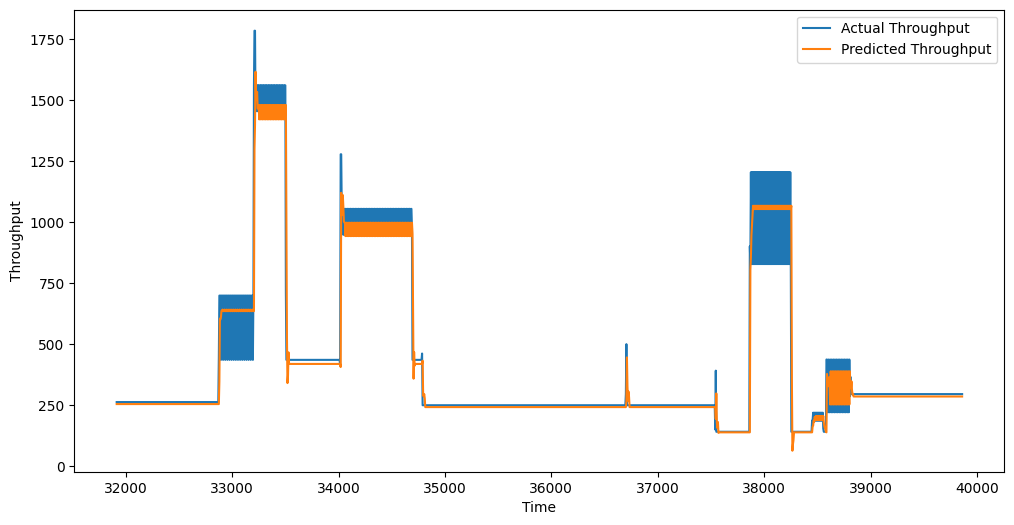

In [ ]:
# 예측 결과와 실제 데이터 비교를 위한 시간 축 조정
time_test = test_time[time_steps:]

# 그래프로 예측 결과와 실제 데이터 비교
plt.figure(figsize=(12, 6))
plt.plot(time_test, y_test, label='Actual Throughput')
plt.plot(time_test, y_pred, label='Predicted Throughput')
plt.xlabel('Time')
plt.ylabel('Throughput')
plt.legend()
plt.show()

#Raspberry Pi 4

IP address = 192.168.0.4

Mac Address = e4:5f:01:71:07:ca

1. Visualize RPi4 captured data

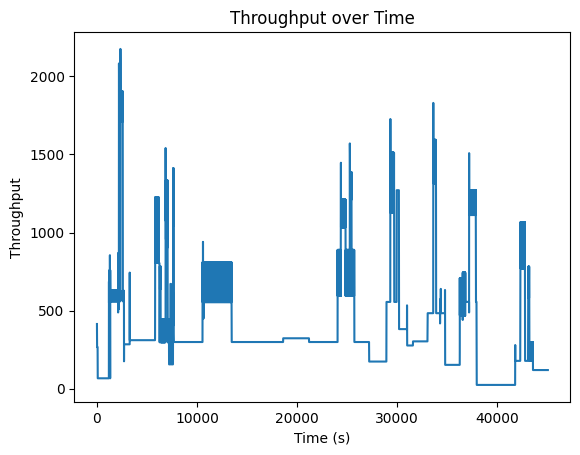

In [ ]:
# 간격과 throughput을 저장할 배열 초기화
interval = 5  # 5초 간격
throughputs = []

# 시작 시간 설정
start_time = packetsFrom04[0].time

# 패킷을 5초 간격으로 그룹화하여 throughput 계산
current_group = []
for packet in packetsFrom04:
    current_group.append(packet)
    if packet.time - start_time >= interval:
        # 패킷 크기를 고려한 throughput 계산 (총 데이터양 / 간격)
        total_bytes = sum(len(pkt) for pkt in current_group)
        throughput = total_bytes / interval
        throughputs.append(throughput)
        # 새로운 그룹 시작
        current_group = []
        start_time = packet.time

# x, y 값 배열 생성
time_axis = np.arange(0, len(throughputs) * interval, interval)
throughput_valuesPi4 = np.array(throughputs)

# 그래프 생성
plt.plot(time_axis, throughput_valuesPi4)
plt.xlabel('Time (s)')
plt.ylabel('Throughput')
plt.title('Throughput over Time')
plt.show()


2. Traffic Prediction

In [ ]:
# 데이터 전처리
data = np.array(throughput_valuesPi4)
time_axis = np.array(time_axis)
data = data.reshape(-1, 1)  # LSTM 모델 입력 형태에 맞게 reshape

# 데이터 분할
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]
train_time, test_time = time_axis[:train_size], time_axis[train_size:]

time_steps = 5  # 시간 스텝 설정
X_train, y_train = create_dataset(train_data, train_data, time_steps)
X_test, y_test = create_dataset(test_data, test_data, time_steps)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 훈련
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)

Epoch 1/50
451/451 [==============================] - 4s 5ms/step - loss: 23998.6992
Epoch 2/50
451/451 [==============================] - 2s 5ms/step - loss: 8223.3428
Epoch 3/50
451/451 [==============================] - 2s 4ms/step - loss: 8520.8809
Epoch 4/50
451/451 [==============================] - 2s 4ms/step - loss: 8374.5469
Epoch 5/50
451/451 [==============================] - 2s 4ms/step - loss: 8039.0562
Epoch 6/50
451/451 [==============================] - 2s 4ms/step - loss: 7647.6636
Epoch 7/50
451/451 [==============================] - 2s 5ms/step - loss: 7454.9321
Epoch 8/50
451/451 [==============================] - 3s 7ms/step - loss: 7222.7222
Epoch 9/50
451/451 [==============================] - 2s 4ms/step - loss: 7419.8882
Epoch 10/50
451/451 [==============================] - 2s 4ms/step - loss: 7131.5547
Epoch 11/50
451/451 [==============================] - 2s 5ms/step - loss: 7071.2705
Epoch 12/50
451/451 [==============================] - 2s 4ms/step - loss

3. Model Estimation

In [ ]:
# 모델의 정확도 출력
mse = model.evaluate(X_test, y_test, verbose=0)
accuracy = 1 - mse / np.var(y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.964062524003404


# Raspberry Pi 5

IP address = 192.168.0.5

Mac address = e4:5f:01:67:6a:0f

1. Visualize RPi5 captured data

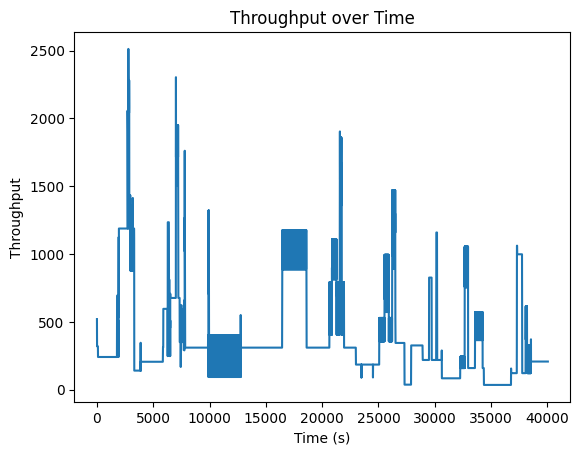

In [ ]:
# 간격과 throughput을 저장할 배열 초기화
interval = 5  # 5초 간격
throughputs = []

# 시작 시간 설정
start_time = packetsFrom05[0].time

# 패킷을 5초 간격으로 그룹화하여 throughput 계산
current_group = []
for packet in packetsFrom05:
    current_group.append(packet)
    if packet.time - start_time >= interval:
        # 패킷 크기를 고려한 throughput 계산 (총 데이터양 / 간격)
        total_bytes = sum(len(pkt) for pkt in current_group)
        throughput = total_bytes / interval
        throughputs.append(throughput)
        # 새로운 그룹 시작
        current_group = []
        start_time = packet.time

# x, y 값 배열 생성
time_axis = np.arange(0, len(throughputs) * interval, interval)
throughput_valuesPi5 = np.array(throughputs)

# 그래프 생성
plt.plot(time_axis, throughput_valuesPi5)
plt.xlabel('Time (s)')
plt.ylabel('Throughput')
plt.title('Throughput over Time')
plt.show()


2. Traffic Prediction

In [ ]:
# 데이터 전처리
data = np.array(throughput_valuesPi5)
time_axis = np.array(time_axis)
data = data.reshape(-1, 1)  # LSTM 모델 입력 형태에 맞게 reshape

# 데이터 분할
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]
train_time, test_time = time_axis[:train_size], time_axis[train_size:]

time_steps = 5  # 시간 스텝 설정
X_train, y_train = create_dataset(train_data, train_data, time_steps)
X_test, y_test = create_dataset(test_data, test_data, time_steps)

# LSTM 모델 생성
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(time_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 모델 훈련
model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# 테스트 데이터로 예측 수행
y_pred = model.predict(X_test)

Epoch 1/50
401/401 [==============================] - 3s 4ms/step - loss: 32621.3652
Epoch 2/50
401/401 [==============================] - 2s 4ms/step - loss: 12625.6572
Epoch 3/50
401/401 [==============================] - 2s 5ms/step - loss: 13007.5137
Epoch 4/50
401/401 [==============================] - 2s 6ms/step - loss: 12778.8857
Epoch 5/50
401/401 [==============================] - 2s 4ms/step - loss: 11658.7363
Epoch 6/50
401/401 [==============================] - 2s 4ms/step - loss: 11815.7539
Epoch 7/50
401/401 [==============================] - 2s 4ms/step - loss: 11915.6367
Epoch 8/50
401/401 [==============================] - 2s 5ms/step - loss: 11058.7607
Epoch 9/50
401/401 [==============================] - 2s 5ms/step - loss: 11501.3154
Epoch 10/50
401/401 [==============================] - 2s 5ms/step - loss: 11241.1572
Epoch 11/50
401/401 [==============================] - 2s 6ms/step - loss: 11377.3838
Epoch 12/50
401/401 [==============================] - 2s 4ms/s

3. Model Estimation

In [ ]:
# 모델의 정확도 출력
mse = model.evaluate(X_test, y_test, verbose=0)
accuracy = 1 - mse / np.var(y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.9380437425515098


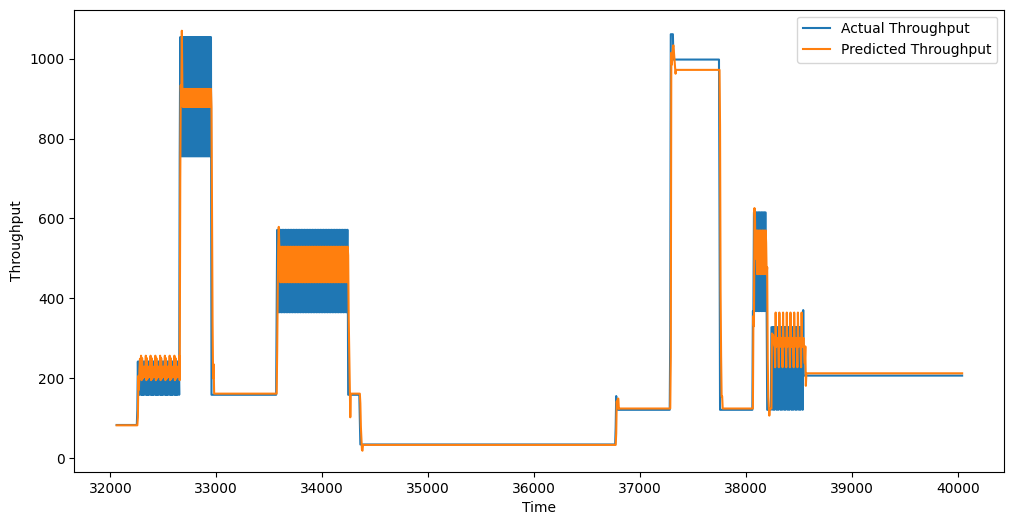

In [ ]:
# 예측 결과와 실제 데이터 비교를 위한 시간 축 조정
time_test = test_time[time_steps:]

# 그래프로 예측 결과와 실제 데이터 비교
plt.figure(figsize=(12, 6))
plt.plot(time_test, y_test, label='Actual Throughput')
plt.plot(time_test, y_pred, label='Predicted Throughput')
plt.xlabel('Time')
plt.ylabel('Throughput')
plt.legend()
plt.show()

# To improve model..

모델의 복잡성 조정: 모델에 있는 LSTM 층의 유닛 수나 층의 개수를 조정하여 모델의 복잡성을 변경할 수 있습니다. 복잡한 모델일수록 더 복잡한 패턴을 학습할 수 있지만, 과적합(overfitting)의 가능성도 증가합니다. 따라서 적절한 모델 복잡성을 선택해야 합니다.
1. Hyperparameter control (layer's unit number, epoch number, layer number)
2. Learning rate control (more faster? more slower?)
3. Use other model (Neural Network Model that can handle traffic data)

During handling, I need to consider overfitting.